In [13]:
from advanced_ta import LorentzianClassification
import yfinance as yf
import numpy as np
import pandas as pd

stock = yf.download('AAPL', start='2014-01-01', end='2024-01-01')
#stock = pd.read_csv('AAPL_dollar_bars_1516_500M.csv')

stock['open'] = stock['Open']
stock['high'] = stock['High']
stock['low'] = stock['Low']
stock['close'] = stock['Close']
stock['volume'] = stock['Volume']
# df here is the dataframe containing stock data as [['open', 'high', 'low', 'close', 'volume']]. Notice that the column names are in lower case.
lc = LorentzianClassification(stock)


c:\Users\adria\miniconda3\envs\lorentzian\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [14]:
from advanced_ta import LorentzianClassification
from ta.volume import money_flow_index as MFI

# stock here is the dataframe containing stock data as [['open', 'high', 'low', 'close', 'volume']]. Notice that the column names are in lower case.
lc = LorentzianClassification(
        stock,
        features=[
            LorentzianClassification.Feature("RSI", 21, 2),  # f1
            LorentzianClassification.Feature("WT", 10, 11),  # f2
            LorentzianClassification.Feature("CCI", 20, 2),  # f3
            LorentzianClassification.Feature("ADX", 20, 2),  # f4
            LorentzianClassification.Feature("RSI", 9, 2),   # f5
            
            #MFI(stock['high'], stock['low'], stock['close'], stock['volume'], 14) #f6
        ],
        settings=LorentzianClassification.Settings(
            source=stock['close'],
            neighborsCount=2,
            maxBarsBack=20000,
            useDynamicExits=False
        ),
        filterSettings=LorentzianClassification.FilterSettings(
            useVolatilityFilter=True,
            useRegimeFilter=True,
            useAdxFilter=False,
            regimeThreshold=-0.1,
            adxThreshold=20,
            kernelFilter = LorentzianClassification.KernelFilter(
                useKernelSmoothing = False,
                lookbackWindow = 8,
                relativeWeight = 8.0,
                regressionLevel = 25,
                crossoverLag = 2
            )
        ))

In [15]:
stock["Tomorrow"] = stock["Close"].shift(-1)
stock['diff'] = stock['Close'].diff()
stock["Target"] = (stock["Tomorrow"]> stock["Close"]).astype(int)
labels = stock['Target']

In [16]:
lc.data['signal'] = lc.data['signal'].replace(-1, 0)
#prediction_array = lc.data['signal']
prediction_array = (lc.data['prediction'] > 0).astype(int)

C:\Users\adria\AppData\Local\Temp\ipykernel_14704\1336794953.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lc.data['signal'] = lc.data['signal'].replace(-1, 0)


In [17]:

# Download AAPL closing prices
#aapl_closing = yf.download('AAPL', start='2018-01-01', end='2024-01-01')["Close"]
#aapl_closing = pd.read_csv('AAPL_dollar_bars1516.csv')['Close']

# Focus on the last 5% of the period


# Calculate daily returns for the last 5%
maxBarsBack = 0

actuals_daily_returns = lc.data['close'].pct_change()

# Ensure 'signals' is aligned in size with 'actuals_daily_returns'
# This might involve slicing 'predictions_array' to match the exact period of 'last_five_percent'
signals = prediction_array[-len(actuals_daily_returns):]  # Adjust this line as necessary
#signals = (actuals_daily_returns > 0).astype(int)
# Calculate strategy daily returns
strategy_daily_returns = signals * actuals_daily_returns

strategy_daily_returns = strategy_daily_returns[maxBarsBack:]
actuals_daily_returns = actuals_daily_returns[maxBarsBack:]
# Calculate performance metrics
cumulative_return = np.prod(strategy_daily_returns + 1) - 1
negative_returns = strategy_daily_returns[strategy_daily_returns < 0]
downside_deviation = np.sqrt(np.mean(negative_returns ** 2))
expected_return = np.mean(strategy_daily_returns)
risk_free_rate = 0  # Adjust as necessary
sortino_ratio = (expected_return - risk_free_rate) / downside_deviation if downside_deviation != 0 else np.nan

# Display Performance Metrics
print("\nTrading Strategy Performance:")
print(f"Cumulative Return: {cumulative_return * 100:.2f}%")
print(f"Downside Deviation: {downside_deviation:.4f}")
print(f"Sortino Ratio: {sortino_ratio:.4f}")


Trading Strategy Performance:
Cumulative Return: 29931.61%
Downside Deviation: 0.0112
Sortino Ratio: 0.2084


In [18]:
def sharpe(returns, risk_free=0):
    adj_returns = returns - risk_free
    return (np.nanmean(adj_returns) * np.sqrt(252)) \
        / np.nanstd(adj_returns, ddof=1)

def downside_risk(returns, risk_free=0):
    adj_returns = returns - risk_free
    sqr_downside = np.square(np.clip(adj_returns, np.NINF, 0))
    return np.sqrt(np.nanmean(sqr_downside) * 252)


def sortino(returns, risk_free=0):
    adj_returns = returns - risk_free
    drisk = downside_risk(adj_returns)

    if drisk == 0:
        return np.nan

    return (np.nanmean(adj_returns) * np.sqrt(252)) \
        / drisk

sortino(strategy_daily_returns)

0.45522589155297355

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


actuals_array = (actuals_daily_returns > 0).astype(int)
predictions_array = signals.tolist()[maxBarsBack:]

# Calculate various classification metrics
accuracy = accuracy_score(actuals_array, predictions_array)
precision = precision_score(actuals_array, predictions_array)
recall = recall_score(actuals_array, predictions_array)
f1 = f1_score(actuals_array, predictions_array)
conf_matrix = confusion_matrix(actuals_array, predictions_array)


# Print out the metrics
print("For Lorentzian classification predictions")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

For Lorentzian classification predictions
Accuracy: 0.5886
Precision: 0.6080
Recall: 0.6212
F1 Score: 0.6145
Confusion Matrix:
[[656 532]
 [503 825]]


In [20]:
actuals_array = (actuals_daily_returns > 0).astype(int)
buyAndHold = np.ones(len(actuals_array)) 


# Calculate various classification metrics
accuracy = accuracy_score(actuals_array, buyAndHold)
precision = precision_score(actuals_array, buyAndHold)
recall = recall_score(actuals_array, buyAndHold)
f1 = f1_score(actuals_array, buyAndHold)
conf_matrix = confusion_matrix(actuals_array, buyAndHold)


# Print out the metrics
print("For buy and hold")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

For buy and hold
Accuracy: 0.5278
Precision: 0.5278
Recall: 1.0000
F1 Score: 0.6909
Confusion Matrix:
[[   0 1188]
 [   0 1328]]


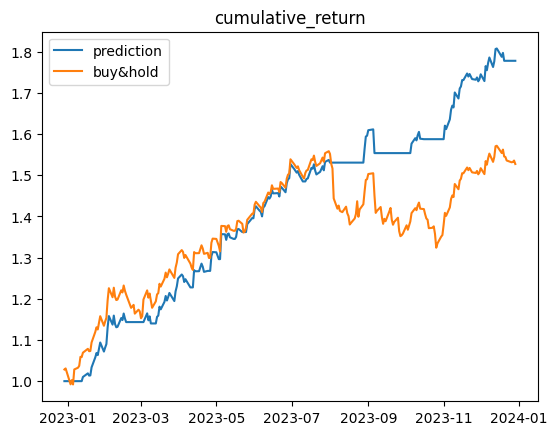

In [21]:
import matplotlib.pyplot as plt
plt.title('cumulative_return')
plt.plot((strategy_daily_returns+1)[-252:].cumprod())
plt.plot((actuals_daily_returns+1)[-252:].cumprod())
plt.legend(['prediction', 'buy&hold'], loc='upper left')

In [22]:
np.mean(strategy_daily_returns),np.mean(actuals_daily_returns)

(0.002325261933232925, 0.0010657190793902645)

In [23]:
stock['prediction'] = lc.data['prediction']
stock['signal'] = lc.data['signal']
stock['Target'].corr(stock['signal'])

0.024738061692643736

In [24]:
stock['prediction']

Date
2014-01-02    0
2014-01-03    0
2014-01-06    0
2014-01-07    0
2014-01-08    0
             ..
2023-12-22   -2
2023-12-26   -2
2023-12-27   -2
2023-12-28   -2
2023-12-29   -2
Name: prediction, Length: 2516, dtype: int32